# Xpand IT DS Challenge

## Business Analysis

-----
The Dow Jones [Industrial] Index (DJIA) is a stock market index founded in February 16, 1885, as DJA, and renamed to DJIA in May 26, 1896. Nowadays, the index comprises 30 blue chip companies listed on the New York stock exchange and the Nasdaq. These companies operate on industries ranging from information technology or financial services to retailing or food industry, to name a few. The largest index weight is held by UnitedHealth Group, at 8.81%, followed closely by Microsoft and Goldman Sachs at 6.83% and 6.54%, respectively. It also includes other internationally recognised companies, such as Apple, McDonald's and Visa, for instance.

Unlike other common indexes, the Dow Jones Index is price-weighted, as opposed to being weighted by market capitalisation. As such, stocks with higher share prices have a greater influence. The DJIA is calculated by dividing the sum of the prices of all component stocks, $\sum p$, by the Dow Divisor, $d$. As of February 2024, the Dow Divisor was set at 0.15265312230608.

The Dow Jones Index is reevaluated on a regular basis, replacing companies that no longer meet the eligibility criteria.

-----


## Data Understanding
During the data understanding phase, you should focus on understanding what each variable represents, compute statistics and visualizations. Some questions that may guide your work follow:
* Feature engineering: should new features be created from the existing ones?
* What will be your features and your label?
* Is the dataset ready for the prediction task? (ex: missing values)
* How will the data be split into train and test sets?

-----

Note that Python 3.11 was used in this notebook.

#### Imports

In [1]:
!pip install pandas seaborn matplotlib numpy scikit-learn imblearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE

#### Load data

In [3]:
with open('data/dow_jones_index.names') as f:
    print(f.read())

This dataset was first used in:
Brown, M. S., Pelosi, M. & Dirska, H. (2013). Dynamic-radius Species-conserving Genetic Algorithm for 
the Financial Forecasting of Dow Jones Index Stocks. Machine Learning and Data Mining in Pattern 
Recognition, 7988, 27-41.

Number of Instances
There are 750 data records.  360 are from the first quarter of the year (Jan to Mar)
390 are from the second quarter of the year (Apr to Jun).

Number of Attributes
There are 16 attributes. 

For each Attribute
	quarter:  the yearly quarter (1=Jan-Mar; 2=Apr-Jun)
	stock: the stock symbol (see below)
	date: the last business day of the work (this is typically a Friday)
	open: the price of the stock at the beginning of the week
	high: the highest price of the stock during the week
	low: the lowest price of the stock during the week
	close: the price of the stock at the end of the week
	volume: the number of shares of stock that traded hands in the week
	percent_change_price: the percentage change in price through

In [4]:
data = pd.read_csv('data/dow_jones_index.data')
data.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


The dataset contains 16 attributes, well described in the dow_jones_index.names file. Already missing values can be noted in the columns percent_change_next_weeks_price and previous weeks_volume. This likely corresponds to the first day recorded. Every date corresponds to a Friday. The dataset is not ready for the prediction task, as it contains missing values and some columns ar not in the correct data type (price columns, for instance). The percent_change_next_weeks_price column is the most valuable for the prediction task, as it represents the percentage change in price from the current week to the next week.

In [5]:
len(data)

750

The dataset only contains 720 rows, which is little, especially considering each row corresponds to one of 30 stocks every friday. This means that 720/30=24 data points are available for each stock. With so few data points, models may not be able to generalise well, and Artificial Neural Networks may not be the best choice, as they require large datasets and are likely to overfit.

#### Check data types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

The date column is of type object. It should be converted to datetime for easier handling. The price columns are also of type object and contain dollar signs. These will be removed and converted to float.

In [7]:
data['date'] = pd.to_datetime(data['date'])
price_columns = ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']
data[price_columns] = data[price_columns].replace('[\$,]', '', regex=True).astype(float)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    int64         
 1   stock                               750 non-null    object        
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    float64       
 4   high                                750 non-null    float64       
 5   low                                 750 non-null    float64       
 6   close                               750 non-null    float64       
 7   volume                              750 non-null    int64         
 8   percent_change_price                750 non-null    float64       
 9   percent_change_volume_over_last_wk  720 non-null    float64       
 10  previous_weeks_volume     

#### Basic statistics

In [9]:
data.describe()

,quarter,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
count,750.000000,750,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,720.000000,7.200000e+02,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.520000,2011-03-31 23:02:24,53.651840,54.669987,52.640160,53.729267,1.175478e+08,0.050262,5.593627,1.173876e+08,53.702440,53.889080,0.238468,52.525333,0.691826
min,1.000000,2011-01-07 00:00:00,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-15.422900,-61.433175,9.718851e+06,10.520000,10.520000,-15.422900,0.000000,0.065574
25%,1.000000,2011-02-18 00:00:00,29.830000,30.627500,28.720000,30.365000,3.086624e+07,-1.288053,-19.804284,3.067832e+07,30.315000,30.462500,-1.222068,24.000000,0.534549
50%,2.000000,2011-04-01 00:00:00,45.970000,46.885000,44.800000,45.930000,5.306088e+07,0.000000,0.512586,5.294556e+07,46.015000,46.125000,0.101193,47.000000,0.681067
75%,2.000000,2011-05-13 00:00:00,72.715000,74.287500,71.037500,72.667500,1.327218e+08,1.650888,21.800622,1.333230e+08,72.715000,72.915000,1.845562,69.000000,0.854291
max,2.000000,2011-06-24 00:00:00,172.110000,173.540000,167.820000,170.580000,1.453439e+09,9.882230,327.408924,1.453439e+09,172.110000,174.540000,9.882230,336.000000,1.564210
std,0.499933,NaN,32.638852,33.215994,32.119277,32.788787,1.584381e+08,2.517809,40.543478,1.592322e+08,32.778111,33.016677,2.679538,46.335098,0.305482


The percent_change_next_weeks_price column has a high discrepancy between minimum and maximum values, which suggests the presence of outliers. Given the nature of the stock market, this is expected. It would not be beneficial to remove these outliers, as they are likely to be valuable data points for the prediction task, especially given the small dataset.

Now, to check for missing values:

In [10]:
data.isnull().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

Considering the importance of the columns where missing values are detected, the best policy will be to drop rows with missing values.

In [11]:
data = data.dropna()

Find all dates

In [12]:
data['date'].unique()

<DatetimeArray>
['2011-01-14 00:00:00', '2011-01-21 00:00:00', '2011-01-28 00:00:00',
 '2011-02-04 00:00:00', '2011-02-11 00:00:00', '2011-02-18 00:00:00',
 '2011-02-25 00:00:00', '2011-03-04 00:00:00', '2011-03-11 00:00:00',
 '2011-03-18 00:00:00', '2011-03-25 00:00:00', '2011-04-01 00:00:00',
 '2011-04-08 00:00:00', '2011-04-15 00:00:00', '2011-04-21 00:00:00',
 '2011-04-29 00:00:00', '2011-05-06 00:00:00', '2011-05-13 00:00:00',
 '2011-05-20 00:00:00', '2011-05-27 00:00:00', '2011-06-03 00:00:00',
 '2011-06-10 00:00:00', '2011-06-17 00:00:00', '2011-06-24 00:00:00']
Length: 24, dtype: datetime64[ns]

#### Plot evolution of percent_change_price for each stock

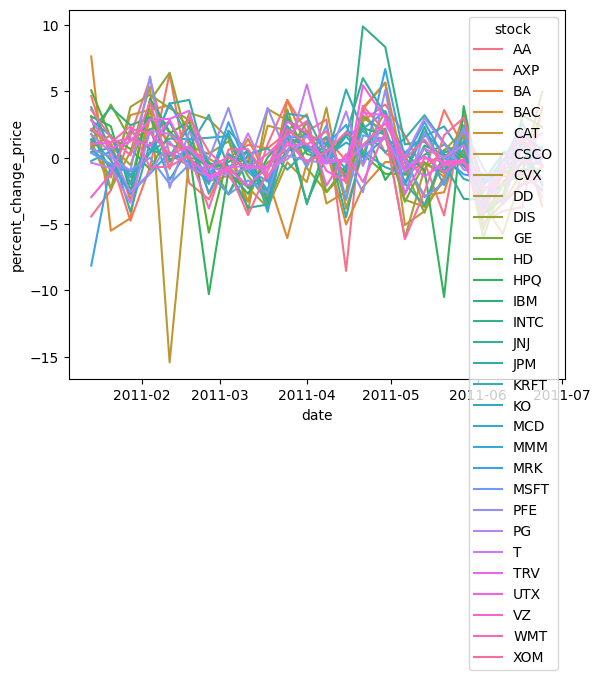

In [13]:
sns.lineplot(data=data, x='date', y='percent_change_price', hue='stock')
plt.show()

Some stocks seem to be more volatile than others, with larger fluctuations in the percent_change_price. This is expected, as some stocks are more volatile than others. This information can be valuable for the prediction task.

#### Plot correlation

In [14]:
#take day and month from date
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

<Axes: >

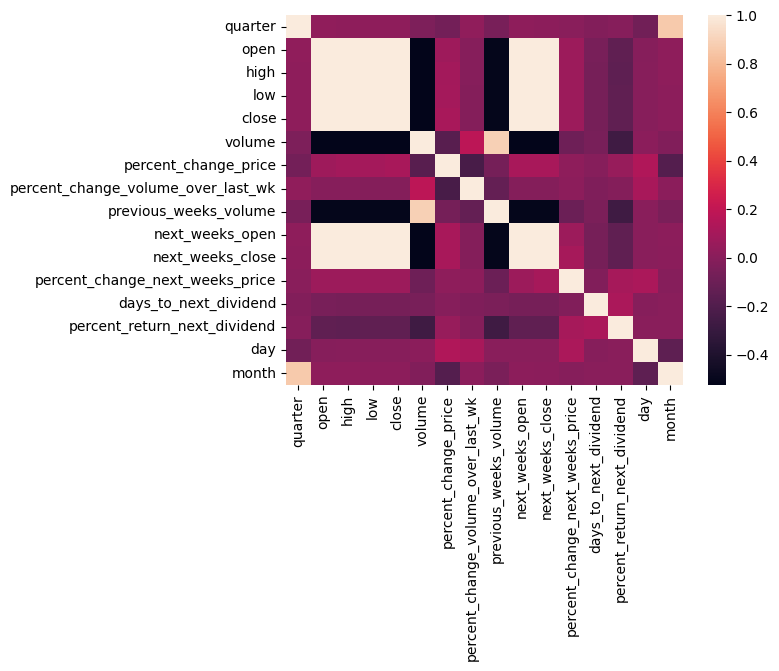

In [15]:
corr = data.drop(columns=['date', 'stock']).corr()
sns.heatmap(corr)

The percent_change_next_weeks_price column has a low correlation with all features, which suggests that it is not dependent on them, and the prediction task will be challenging.

#### Feature engineering

Stock values are known to be difficult to predict. Additionally, there are only 24 data points for each stock, which means that regression models to predict percent change in price may not be the best choice. Instead, two approaches will be made:
* Rank the stocks by percent_change_next_weeks_price, and predict the rank of each stock (where 1 is the best stock and 30 is the worst stock);
* For each day, find the maximum value in percent_change_price, and the corresponding stock. Assign 1 to the stock with the maximum value, and 0 to the others in a new column called 'best_stock'. This will be a classification task.

First, determine whether a stock is the best stock for a given day, and rank the stocks by percent_change_next_weeks_price.

In [16]:
data['best_stock'] = data.groupby('date')['percent_change_next_weeks_price'].transform('max') == data['percent_change_next_weeks_price']
data['rank'] = data.groupby('date')['percent_change_next_weeks_price'].rank(ascending=False)

Now, one hot encode the stock column.

In [17]:
original_data = data.copy()

In [18]:
data = pd.get_dummies(data, columns=['stock'])

Now, sort the data by date for easier manipulation.

In [19]:
data = data.sort_values('date')
data

,quarter,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,...,stock_MRK,stock_MSFT,stock_PFE,stock_PG,stock_T,stock_TRV,stock_UTX,stock_VZ,stock_WMT,stock_XOM
1,1,2011-01-14,16.71,16.71,15.64,15.97,242963398,-4.428490,1.380223,239655616.0,...,False,False,False,False,False,False,False,False,False,False
61,1,2011-01-14,20.94,21.23,20.70,21.21,154708263,1.289400,-49.032988,303545878.0,...,False,False,False,False,False,False,False,False,False,False
73,1,2011-01-14,90.95,92.85,90.12,92.83,28260512,2.067070,-20.518947,35556288.0,...,False,False,False,False,False,False,False,False,False,False
85,1,2011-01-14,48.30,49.80,47.20,49.80,34546875,3.105590,24.903787,27658789.0,...,False,False,False,False,False,False,False,False,False,False
97,1,2011-01-14,39.01,39.81,38.92,39.29,31943413,0.717765,-56.192464,72917621.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2,2011-06-24,24.17,24.86,24.16,24.30,309206180,0.537857,10.261383,280430166.0,...,False,True,False,False,False,False,False,False,False,False
502,2,2011-06-24,34.29,35.69,34.28,35.08,65416820,2.303880,-14.260438,76297124.0,...,False,False,False,False,False,False,False,False,False,False
424,2,2011-06-24,96.49,102.50,96.05,100.01,43722864,3.648050,0.267013,43606429.0,...,False,False,False,False,False,False,False,False,False,False
593,2,2011-06-24,65.37,66.82,64.43,64.93,49806614,-0.673092,15.306642,43194922.0,...,False,False,False,False,False,False,False,False,False,False


## Modelling
-----


In [20]:
data.columns

Index(['quarter', 'date', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend', 'day', 'month', 'best_stock', 'rank',
       'stock_AA', 'stock_AXP', 'stock_BA', 'stock_BAC', 'stock_CAT',
       'stock_CSCO', 'stock_CVX', 'stock_DD', 'stock_DIS', 'stock_GE',
       'stock_HD', 'stock_HPQ', 'stock_IBM', 'stock_INTC', 'stock_JNJ',
       'stock_JPM', 'stock_KO', 'stock_KRFT', 'stock_MCD', 'stock_MMM',
       'stock_MRK', 'stock_MSFT', 'stock_PFE', 'stock_PG', 'stock_T',
       'stock_TRV', 'stock_UTX', 'stock_VZ', 'stock_WMT', 'stock_XOM'],
      dtype='object')

#### Ranking

Approaching the ranking problem as a regression, with random forest regressor:

In [21]:

kf = KFold(n_splits=10)
features = ['day', 'month', 'percent_change_price', 'previous_weeks_volume', 'days_to_next_dividend', 'percent_return_next_dividend',
            'stock_AA', 'stock_AXP', 'stock_BA', 'stock_BAC', 'stock_CAT', 'stock_CSCO', 'stock_CVX', 'stock_DD', 'stock_DIS', 'stock_GE',
            'stock_HD', 'stock_HPQ', 'stock_IBM', 'stock_INTC', 'stock_JNJ', 'stock_JPM', 'stock_KO', 'stock_KRFT', 'stock_MCD', 'stock_MMM',
            'stock_MRK', 'stock_MSFT', 'stock_PFE', 'stock_PG', 'stock_T', 'stock_TRV', 'stock_UTX', 'stock_VZ', 'stock_WMT', 'stock_XOM']
label = 'rank'
model = RandomForestRegressor()
for train_index, test_index in kf.split(data):
    X_train, X_test = data.iloc[train_index][features], data.iloc[test_index][features]
    y_train, y_test = data.iloc[train_index][label], data.iloc[test_index][label]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(r2_score(y_test, y_pred))


-0.04095763860180379
-0.033634861304234986
-0.07383639476606052
0.03999284318340324
-0.10771137181144952
0.047650769080043065
-0.06328497409326417
-0.028658883248730893
-0.04790557216506963
-0.12289927767313613


This model performs very poorly. The R2 score is negative in some cases, which means that the model is worse than a horizontal line.

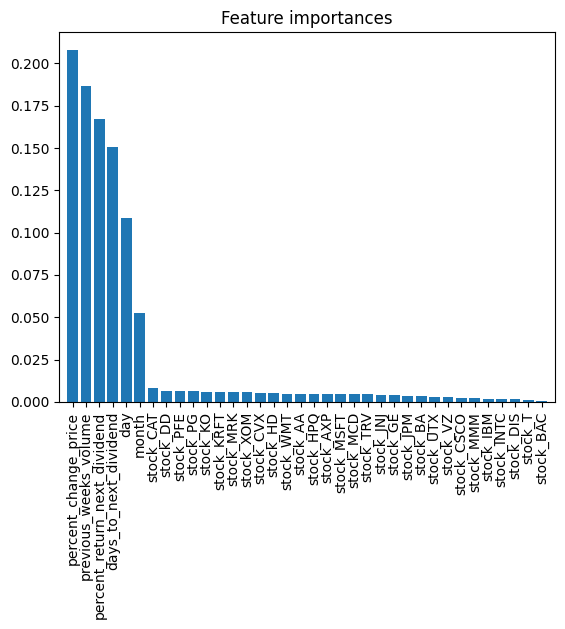

In [22]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")

plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The most important features are percent_change_price, previous_weeks_volume, and percent_return_next_dividend. The stock features are not very important, which suggests that the stock itself is not a good predictor of the rank. By keeping these features we are also risking the curse of dimensionality, meaning that the larger the number of features the larger the number of data points required to make accurate predictions. therefore, the stock features will be dropped.

Now, to leave out the last 7 days for validation and testing the model further.

In [23]:
#leave out the last 7 days for validation
train = data[data['date'] < '2011-05-13']
test = data[data['date'] >= '2011-05-13']

In [24]:
features = ['day', 'month', 'percent_change_price', 'previous_weeks_volume', 'days_to_next_dividend', 'percent_return_next_dividend']
label = 'rank'
model = RandomForestRegressor()
X_train = train[features]
y_train = train[label]
X_test = test[features]
y_test = test[label]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([12.9 , 16.59, 12.96, 16.94, 24.15, 10.99, 22.61, 20.51, 21.22,
       16.79, 14.48, 13.43, 15.47, 17.22, 13.09, 17.59, 12.98, 16.14,
       12.88, 15.83, 13.71, 14.53, 16.82, 13.33, 16.08, 14.9 , 15.67,
       17.47, 12.15, 14.3 , 18.12, 15.58, 17.01, 16.07, 11.57, 15.39,
       17.34, 15.56, 21.66, 13.7 , 15.22, 11.6 , 16.47, 16.36, 16.34,
       14.21, 17.25, 12.24, 16.88, 12.46, 17.2 , 13.22, 14.91, 16.47,
       12.63, 15.37, 12.7 , 21.99, 12.57, 16.49, 15.17, 14.37, 14.39,
       15.87, 17.89, 11.98, 13.97, 17.36, 12.96, 15.16, 16.46, 15.16,
       11.47, 19.09, 16.58, 15.41, 15.76, 16.84, 13.53, 14.45, 15.51,
       15.06, 17.22, 13.45, 13.62, 14.28, 14.03, 16.28, 15.76, 17.35,
       15.94, 15.45, 17.87, 10.36, 11.84, 17.34, 13.12, 12.6 , 15.33,
       15.36, 13.56, 15.07, 18.13, 13.5 , 15.32, 15.85, 16.89, 10.73,
       13.5 , 11.6 , 20.  , 16.93, 14.9 , 14.83, 18.57, 17.98, 13.34,
       17.5 , 15.15, 16.44, 15.66, 15.27, 14.63, 16.44, 13.64, 14.68,
       13.28, 15.69,

In [25]:
#for all 30 in y_pred, rank them and assign the rank to the element out of the 30 in each iteration
y_pred = pd.Series(y_pred)
for i in range(0, len(y_pred), 30):
    y_pred[i:i+30] = y_pred[i:i+30].rank(method='first')

In [26]:
y_pred

0       4.0
1      20.0
2       5.0
3      23.0
4      30.0
       ... 
205    28.0
206    26.0
207     4.0
208    23.0
209     7.0
Length: 210, dtype: float64

In [27]:
#convert y_test to dataframe and concatenate y_pred to it
y_test = pd.DataFrame(y_test)
y_test.reset_index(drop=False, inplace=True)
y_test

,index,rank
0,691,17.0
1,743,3.0
2,457,13.0
3,561,9.0
4,405,28.0
...,...,...
205,645,3.0
206,502,21.0
207,424,1.0
208,593,20.0


In [28]:
y_test = pd.concat([y_test, y_pred], axis=1)

In [29]:
#rename 0 to predicted_rank
y_test.rename(columns={0: 'predicted_rank'}, inplace=True)

In [30]:
y_test

,index,rank,predicted_rank
0,691,17.0,4.0
1,743,3.0,20.0
2,457,13.0,5.0
3,561,9.0,23.0
4,405,28.0,30.0
...,...,...,...
205,645,3.0,28.0
206,502,21.0,26.0
207,424,1.0,4.0
208,593,20.0,23.0


In [31]:
y_test['correct'] = (y_test['predicted_rank'] == y_test['rank']) & (y_test['rank'] == 1)

In [32]:
y_test['correct'].any()

np.False_

The model was not able to predict the best stock for any of the days.

#### Classification

Now, to try to classify the best stock for each day.

In [33]:
features = ['day', 'month', 'percent_change_price', 'previous_weeks_volume', 'days_to_next_dividend', 'percent_return_next_dividend']
label = 'best_stock'
X_train = train[features]
y_train = train[label]
X_test = test[features]
y_test = test[label]

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.97      1.00      0.98       203
        True       0.00      0.00      0.00         7

    accuracy                           0.97       210
   macro avg       0.48      0.50      0.49       210
weighted avg       0.93      0.97      0.95       210



C:\Users\jgalv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jgalv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jgalv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Considering the current class imbalance, we can try to use SMOTE to balance the classes.

In [34]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train = X_resampled
y_train = y_resampled

In [35]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.97      0.99      0.98       203
        True       0.00      0.00      0.00         7

    accuracy                           0.95       210
   macro avg       0.48      0.49      0.49       210
weighted avg       0.93      0.95      0.94       210



The model still performs poorly, uncapable of predicting the best stock for any of the days.

While Random Forests are good algorithms for a first approach, since they handle multiple features and handle nonlinearity without much tuning, they did not provide accurate predictions. This is most likely due to insufficient data and feature engineering.

## Conclusions
-----

The results obtained are highly inaccurate, not so much due to the choice of models but rather the training data. While the modelling phase could benefit from experimenting with different models or tuning, more data should be gathered and better prepared. Furthermore, this problem was approached as a ranking and classification problem. However, it might be better approached with time series analysis.

Random forest models are generally robust to overfitting, handle high dimensional data and are robust to noise, while also being hable to capture non-linear relationships. However, they also tend to be computationally expensive, memory intensive black box models.

In this solution, the Occam's razor principle was applied, starting out with simple but robust models. The fact that even these were completely unable to establish any relationship between the features and the targets suggests that it is necessary to:
* Gather more data points: 750 data points are insufficient for a problem as complex as stock market value prediction;
* Improve feature engineering: more features can be extracted to capture seasonality and even transform this problem into a time series analysis and forecasting;
* Add more data sources: the stock market is influenced by several factors, such as the economy, the news and politics. Economic indicators can be relevant features, and sentiment analysis could be used to include data from social media or the news.

Finally, the stock market is remarkably difficult to predict, with stock values being extremely volatile and most researchers struggling to develop models that can predict the best stock to invest in better than a random guess. Such task actually implies a much more extensive research and work.

-----

#### Feedback

-----

This is an extremely challenging but interesting task, which I am not sure is solvable in so little time. However, some interesting insights are drawn from the exploratory data analysis and modelling. Perhaps supplying more data would be a good idea, or making it clear if gathering more data would be acceptable to solve this challenge.